In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch
from pyjet import cluster,DTYPE_PTEPM
import math

# Pre processing + Define Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNet(nn.Module):
    def __init__(self, input_dim=4, big_dim=32, hidden_dim=2, aggr='mean'):
        super(EdgeNet, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(input_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, hidden_dim),
                               nn.ReLU(),
        )
        
        decoder_nn = nn.Sequential(nn.Linear(2*(hidden_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)
        self.decoder = EdgeConv(nn=decoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x,data.edge_index)
        data.x = self.decoder(data.x,data.edge_index)
        return data.x

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/')

input_dim = 4
big_dim = 32
hidden_dim = 2
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 512
n_epochs = 1
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNet'

model = EdgeNet(input_dim=input_dim, big_dim=big_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [4]:
train_dataset = GraphDataset(root='/anomalyvol/data/',start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)

24043
2405
2405


In [5]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [6]:
modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')

In [ ]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

In [7]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())
    del data
    torch.cuda.empty_cache()

 85%|████████▌ | 4/4.697265625 [03:15<00:34, 49.93s/it]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
106%|██████████| 5/4.697265625 [03:47<-1:59:47, 45.51s/it]


# Visualize

In [8]:
def in_out_diff_append(diff, output, inputs, i, ft_idx): # helper for appending 3 lists
    diff.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output.append(output_x[i][:,ft_idx].flatten())
    inputs.append(input_x[i][:,ft_idx].flatten())

def in_out_diff_concat(diff, output, inputs):
    diff = np.concatenate(diff)
    output = np.concatenate(output)
    inputs = np.concatenate(inputs)
    return [diff, output, inputs]

def make_hists(diff, output, inputs, bin1):
    plt.figure()
    plt.hist(inputs, bins=bin1,alpha=0.5)
    plt.hist(output, bins=bin1,alpha=0.5)
    plt.show()

    plt.figure()
    plt.hist(diff, bins=np.linspace(-5, 5, 101))
    plt.show()

px


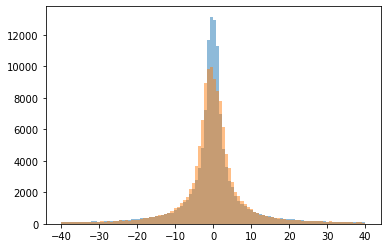

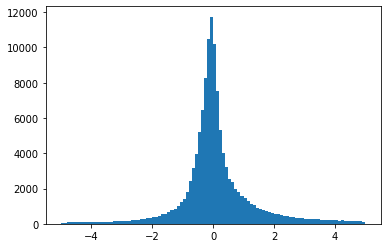

py


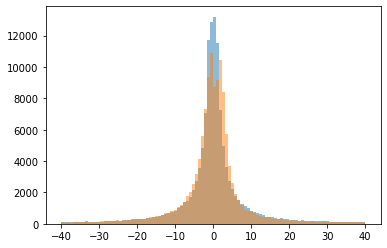

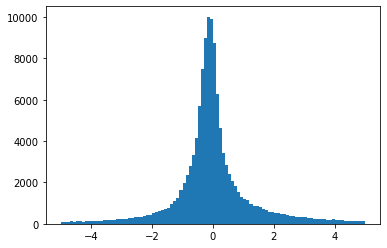

pz


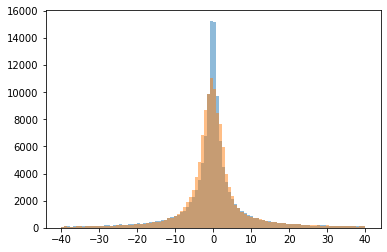

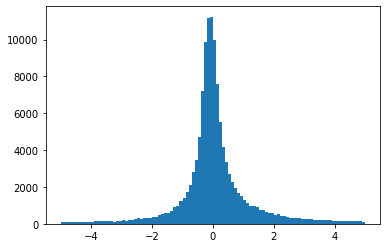

e


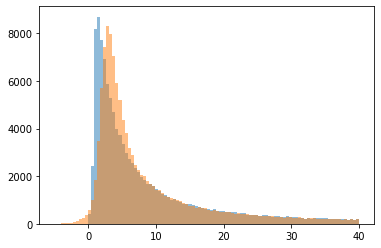

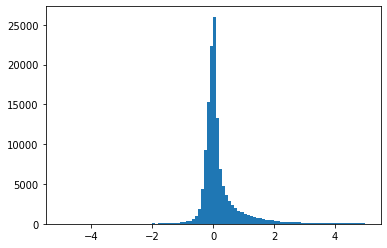

In [9]:
diff_px = []
output_px = []
input_px = []
diff_py = []
output_py = []
input_py = []
diff_pz = []
output_pz = []
input_pz = []
diff_e = []
output_e = []
input_e = []

# get output in readable format
for i in range(len(input_x)):
    # px
    in_out_diff_append(diff_px, output_px, input_px, i, 0)
    in_out_diff_append(diff_py, output_py, input_py, i, 1)
    in_out_diff_append(diff_pz, output_pz, input_pz, i, 2)
    in_out_diff_append(diff_e, output_e, input_e, i, 3)

# remove extra brackets
diff_px, output_px, input_px = in_out_diff_concat(diff_px, output_px, input_px)
diff_py, output_py, input_py = in_out_diff_concat(diff_py, output_py, input_py)
diff_pz, output_pz, input_pz = in_out_diff_concat(diff_pz, output_pz, input_pz)
diff_e, output_e, input_e = in_out_diff_concat(diff_e, output_e, input_e)

print("px")
bins = np.linspace(-40, 40, 101)
make_hists(diff_px, output_px, input_px, bins)

print("py")
make_hists(diff_py, output_py, input_py, bins)

print("pz")
make_hists(diff_pz, output_pz, input_pz, bins)

print("e")
bins = np.linspace(-5, 40, 101)
make_hists(diff_e, output_e, input_e, bins)

# Bump Hunt

In [10]:
# get losses 
losses = []
model.eval()
mse = nn.MSELoss(reduction='mean')
num_exceptions = 0

t = tqdm.tqdm(enumerate(gdata))
for i, data in t:
    try:
        with torch.no_grad():
            data = data.to(device)
            batch_output = model(data)
            batch_loss_item = mse(batch_output, data.y).item()
            losses.append(batch_loss_item)
    except:
        num_exceptions += 1
        losses.append(0)

24043it [32:06, 12.48it/s]


In [11]:
# get invariant mass of jets
masses = []
t = tqdm.tqdm(enumerate(gdata))
for idx, data in t:
    i_mass_sq = data.x[:,3:4].sum()**2 - data.x[:,0:1].sum()**2 - data.x[:,1:2].sum()**2 - data.x[:,2:3].sum()**2
    if i_mass_sq > 0:
        masses.append(math.sqrt(i_mass_sq))
    else:
        masses.append(0)

24043it [04:06, 97.48it/s] 


In [12]:
cut = 0.95
mse_thresh = np.quantile(losses, cut)
outliers = losses > mse_thresh
mass_outliers = zip(masses, outliers)
outlier_mass = np.array([x[0] for x in mass_outliers if x[1] == True])
all_mass = np.array(masses)

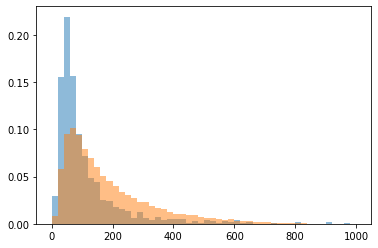

In [13]:
bins = np.linspace(0, 1000, 51)
weights = np.ones_like(outlier_mass) / len(outlier_mass)
plt.hist(outlier_mass, alpha = 0.5, bins=bins, weights=weights)
weights = np.ones_like(all_mass) / len(all_mass)
plt.hist(all_mass, alpha = 0.5, bins=bins, weights=weights)
plt.show()